# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 

In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project. Check out the writeup template for this project and use it as a starting point for creating your own writeup.

## The Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [135]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import glob
import decimal
%matplotlib inline

## Camera Calibration: Correcting for Distortion

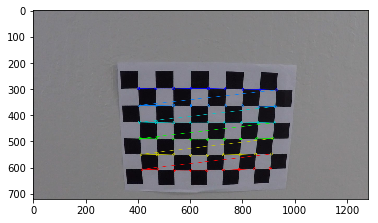

In [136]:
def get_img_and_obj_points(images):

    # Arrays to store object points and image points from all the images

    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (8,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

    for fname in images:
        # read in each image
        img = mpimg.imread(fname)

        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If corners are found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            # draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(img)
            
    return imgpoints, objpoints

# Read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

imgpoints, objpoints = get_img_and_obj_points(images)

img = cv2.imread('camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

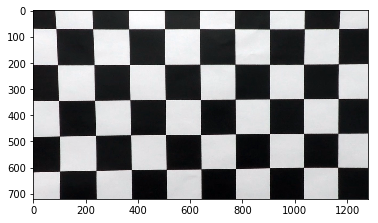

In [137]:
# Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')

undist = cv2.undistort(img, mtx, dist, None, mtx)

#cv2.imwrite('output_images/undistort_output.png', cv2.cvtColor(undist, cv2.COLOR_RGB2BGR))

plt.imshow(undist)


In [138]:
import math
import statistics


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def inner_region_of_interest(img, vertices):
    """
    Applies an image mask for inside the lane.
    
    Defined inner region of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   

    ignore_mask_color = 0
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    masked_image = cv2.fillPoly(img, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    #masked_image = cv2.bitwise_and(img, mask)
    return masked_image




In [139]:
def color_thresholding(img, sobel_kernel=15, thresh=(0.7, 1.3), thresh_min=20, thresh_max=100, s_thresh_min=170, s_thresh_max=255):    
    """
    Applies color_thresholding to the input image.
    
    Combination of thresholding grayscaled, R-channel, B-channel, 
    sobel-operator and the H-channel and S-channel of HLS color transform.    
    
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    thresh_gray = (220, 255)
    binary[(gray > thresh_gray[0]) & (gray <= thresh_gray[1])] = 1
    
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    thresh_r = (230, 255)
    r_binary = np.zeros_like(R)
    r_binary[(R > thresh_r[0]) & (R <= thresh_r[1])] = 1
    
    thresh_b = (50, 255)
    b_binary = np.zeros_like(R)
    b_binary[(B > thresh_r[0]) & (B <= thresh_r[1])] = 1
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    #thresh_min = 20
    #thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    thresh_h = (45, 60)
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel > thresh_h[0]) & (h_channel <= thresh_h[1])] = 1
    
    # Threshold color channel
    #s_thresh_min = 170
    #s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
        
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(binary == 1) | (r_binary == 1) | (s_binary == 1) | (h_binary == 1) | (sxbinary == 1)] = 1 #
    
    
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(combined_binary) # Remove this line
    return binary_output
    
def warper(masked_binary, img_size, imshape):
    """
    Warps the image to birds eye view
    
    Definition of src and dst points and usage of cv2.getPerspectiveTransform()
    and cv2.warpPerspective()
    """
    src = np.float32(
    [[687,450],
    [1120,imshape[0]],
    [195,imshape[0]],
    [592,450]])
    
    offset = 350 # offset for dst points
    dst = np.float32([[img.shape[1]-offset, 0], 
                     [img.shape[1]-offset, imshape[0]], 
                     [offset, imshape[0]], 
                     [offset, 0]])

    # get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # warp your image to a top-down view
    binary_warped = cv2.warpPerspective(masked_binary, M, img_size, flags=cv2.INTER_LINEAR)
    return binary_warped, M


In [140]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def window_search(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    pixelnumberleft = leftx.size
    pixelnumberright = rightx.size
    
    # Define conversions in x and y from pixels space to meters
    #ym_per_pix = 30/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit a second order polynomial to each using `np.polyfit`
    #left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_cr = np.polyfit(lefty*laneimage.ym_per_pix, leftx*laneimage.xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*laneimage.ym_per_pix, rightx*laneimage.xm_per_pix, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    leftlane.last_fitx = leftlane.fitx
    rightlane.last_fitx = rightlane.fitx
    
    try:
        leftlane.fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        rightlane.fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        leftlane.left_fitx = 1*ploty**2 + 1*ploty
        rightlane.right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # Plots the left and right polynomials on the lane lines
    #plt.plot(leftlane.fitx, ploty, color='purple')
    #plt.plot(rightlane.fitx, ploty, color='purple')
        
    return out_img, pixelnumberleft, pixelnumberright, left_fit, right_fit, ploty, left_fit_cr, right_fit_cr

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    left_fit_cr = np.polyfit(lefty*laneimage.ym_per_pix, leftx*laneimage.xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*laneimage.ym_per_pix, rightx*laneimage.xm_per_pix, 2)
    

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, left_fit, right_fit, ploty, left_fit_cr, right_fit_cr

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
        
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    pixelnumberleft = leftx.size
    pixelnumberright = rightx.size

    # Fit new polynomials
    leftlane.last_fitx = leftlane.fitx
    rightlane.last_fitx = rightlane.fitx
    leftlane.fitx, rightlane.fitx, left_fit, right_fit, ploty, left_fit_cr, right_fit_cr = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([leftlane.last_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([leftlane.last_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([rightlane.last_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([rightlane.last_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(leftlane.fitx, ploty, color='yellow')
    #plt.plot(rightlane.fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    #cv2.imwrite('output_images/search_around_poly.png', cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
    
    return result, pixelnumberleft, pixelnumberright, left_fit, right_fit, ploty, left_fit_cr, right_fit_cr

def measure_curvature_pixels():
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    left_fit_cr = leftlane.best_fit_cr
    right_fit_cr = rightlane.best_fit_cr
    ploty = laneimage.ploty
    
    y_eval = np.max(ploty)
        
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*laneimage.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*laneimage.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def measure_curvature_pixels_current():
    '''
    Calculates the current curvature of polynomial functions in pixels.
    '''
    left_fit_cr = leftlane.current_fit_cr
    right_fit_cr = rightlane.current_fit_cr
    ploty = laneimage.ploty
    
    y_eval = np.max(ploty)
        
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*laneimage.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*laneimage.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

def measure_vehicle_position():
    '''
    Calculates the vehicle position from center in meteres.
    left from center is negative, right from center positive
    '''

    imagecenter = laneimage.center_x
    
    lanewidth = rightlane.fitx[-1] - leftlane.fitx[-1] 
    
    halflanewidth = lanewidth/2
    lanecenter = leftlane.fitx[-1] + halflanewidth
    vehicle_position = (imagecenter - lanecenter)*laneimage.xm_per_pix

    return vehicle_position


# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.pixelnumber = 0  
        self.detected = False 
        # absolute difference between last poly and current poly in top of image
        self.absdiff_searcharea = 0
        # x values of the last fit of the line
        self.last_fitx = None
        self.last_n_fitx = None
        self.fitx = [0]
        #polynomial coefficients averaged over the last n iterations
        self.last_fits_cr = None  
        self.best_fit_cr = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        self.current_fit_cr = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        
class LaneImage():
    def __init__(self):
        self.ploty = 0
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        self.last_fit_ctr = 0
        self.center_x = 1280/2
        
leftlane = Line()
rightlane = Line()
laneimage = LaneImage()


In [141]:
def lane_line_finding(binary_warped):
    '''
    Applies a window lane search in the beginning, after it lane search in search area of previous lane position
    Resets to windows lane search if polygons are out of search area or too less lane pixels are detected.
    '''
    searcharea = 80
     
    #window search lane finding and fitting of polynom
    if leftlane.absdiff_searcharea > searcharea or rightlane.absdiff_searcharea > searcharea or leftlane.pixelnumber < 5000 or rightlane.pixelnumber < 5000:
        proc_image, leftlane.pixelnumber, rightlane.pixelnumber, leftlane.current_fit, rightlane.current_fit, laneimage.ploty, leftlane.current_fit_cr, rightlane.current_fit_cr = window_search(binary_warped)
        leftlane.detected = False
        rightlane.detected = False
           
        leftlane.absdiff_searcharea = abs(leftlane.fitx[0] - leftlane.last_fitx[0])
        rightlane.absdiff_searcharea = abs(rightlane.fitx[0] - rightlane.last_fitx[0])
        
    else:
        ###search from prior###
        # search in previous polynom serach area
        proc_image, left_pixelnumber, right_pixelnumber, left_current_fit, right_current_fit, ploty, left_current_fit_cr, right_current_fit_cr = search_around_poly(binary_warped, leftlane.current_fit, rightlane.current_fit)
        
        leftlane.absdiff_searcharea = abs(leftlane.fitx[0] - leftlane.last_fitx[0])
        rightlane.absdiff_searcharea = abs(rightlane.fitx[0] - rightlane.last_fitx[0])
        
        if leftlane.absdiff_searcharea < searcharea or rightlane.absdiff_searcharea < searcharea:
            # saving lane values if its in seracharea if not dont save them and go back to window search
            leftlane.detected = True
            rightlane.detected = True
            leftlane.pixelnumber = left_pixelnumber
            rightlane.pixelnumber = right_pixelnumber
            leftlane.current_fit = left_current_fit
            rightlane.current_fit = right_current_fit
            laneimage.ploty = ploty
            leftlane.current_fit_cr = left_current_fit_cr
            rightlane.current_fit_cr = right_current_fit_cr
                
        else:
            # reset back to window search lane finding if polynom out of serach area detected
            proc_image, leftlane.pixelnumber, rightlane.pixelnumber, leftlane.current_fit, rightlane.current_fit, laneimage.ploty, leftlane.current_fit_cr, rightlane.current_fit_cr = window_search(binary_warped)
            leftlane.detected = False
            rightlane.detected = False

            leftlane.absdiff_searcharea = 0
            rightlane.absdiff_searcharea = 0
            
    # measure specific horizontal distances of left and right polygon to check if the lanes are valid
    
    horizontdist_lanes_bottom = abs(leftlane.fitx[-1] - rightlane.fitx[-1])
    horizontdist_lanes_top = abs(leftlane.fitx[50] - rightlane.fitx[50])
    diff_horizondist_top = abs(horizontdist_lanes_bottom - horizontdist_lanes_top)
    
    horizontdist_lanes_bottom = abs(leftlane.fitx[-1] - rightlane.fitx[-1])
    horizontdist_lanes_lowertop = abs(leftlane.fitx[200] - rightlane.fitx[200])
    diff_horizondist_lowertop = abs(horizontdist_lanes_bottom - horizontdist_lanes_lowertop)
    
    horizontdist_lanes_bottom = abs(leftlane.fitx[-1] - rightlane.fitx[-1])
    horizontdist_lanes_mid = abs(leftlane.fitx[450] - rightlane.fitx[450])
    diff_horizondist_mid = abs(horizontdist_lanes_bottom - horizontdist_lanes_mid)
    
        
    # Calculate the radius of curvature in pixels for both lane lines
    #left_radius_of_curvature_current, right_radius_of_curvature_current = measure_curvature_pixels_current()
    #diff_curvature_current = abs(left_radius_of_curvature_current - right_radius_of_curvature_current)
        
    if laneimage.last_fit_ctr < 1:
            leftlane.last_n_fitx = [leftlane.fitx]
            rightlane.last_n_fitx = [rightlane.fitx]

            leftlane.last_fits_cr = [leftlane.current_fit_cr]
            rightlane.last_fits_cr = [rightlane.current_fit_cr]

            leftlane.best_fitx = [leftlane.fitx]
            rightlane.best_fitx = [rightlane.fitx]

            leftlane.best_fit_cr = leftlane.current_fit_cr
            rightlane.best_fit_cr = rightlane.current_fit_cr
    
    if diff_horizondist_top < 60 and diff_horizondist_lowertop < 60 and diff_horizondist_mid < 60:
        #save correctly detected lane lines in lists and average over them to have a smooth result
        if laneimage.last_fit_ctr < 3:
            #fill lane line lists in the beginning
            leftlane.last_n_fitx.append(leftlane.fitx)
            rightlane.last_n_fitx.append(rightlane.fitx)

            leftlane.last_fits_cr.append(leftlane.current_fit_cr)
            rightlane.last_fits_cr.append(rightlane.current_fit_cr)
            
            leftlane.best_fitx = np.average(leftlane.last_n_fitx, axis=0)
            rightlane.best_fitx = np.average(rightlane.last_n_fitx, axis=0)

            leftlane.best_fit_cr = np.average(leftlane.last_fits_cr, axis=0)
            rightlane.best_fit_cr = np.average(rightlane.last_fits_cr, axis=0)

        else: 
            #throw old lane lines out of list and save the new ones
            leftlane.last_n_fitx.remove(leftlane.last_n_fitx[0])
            leftlane.last_n_fitx.append(leftlane.fitx)

            rightlane.last_n_fitx.remove(rightlane.last_n_fitx[0])
            rightlane.last_n_fitx.append(rightlane.fitx)
            
            leftlane.best_fitx = np.average(leftlane.last_n_fitx, axis=0)
            rightlane.best_fitx = np.average(rightlane.last_n_fitx, axis=0)

            leftlane.last_fits_cr.remove(leftlane.last_fits_cr[0])
            leftlane.last_fits_cr.append(leftlane.current_fit_cr)

            rightlane.last_fits_cr.remove(rightlane.last_fits_cr[0])
            rightlane.last_fits_cr.append(rightlane.current_fit_cr)

            leftlane.best_fit_cr = np.average(leftlane.last_fits_cr, axis=0)
            rightlane.best_fit_cr = np.average(rightlane.last_fits_cr, axis=0)
        
    laneimage.last_fit_ctr = laneimage.last_fit_ctr + 1

In [142]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # Read in the image
    img = mpimg.imread('test_images/'+img)
        
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    
    #cv2.imwrite('output_images/test3_undistort_output.png', cv2.cvtColor(undst, cv2.COLOR_RGB2BGR))
    
    #thresh_min=20, thresh_max=100, s_thresh_min=170, s_thresh_max=255):    
    binary_output = color_thresholding(undst, sobel_kernel=15, thresh=(0.7, 1.3), thresh_min=20, thresh_max=120, s_thresh_min=100, s_thresh_max=255)   
    
    #cv2.imwrite('output_images/test3_binary_combo_example.png', cv2.cvtColor(binary_output, cv2.COLOR_RGB2BGR))
    
    imshape = undst.shape
    
    # Defining a four sided polygon to mask
     
#     vertices = np.array([[(195,imshape[0]),(592, 550), (687, 550), (1115,imshape[0])]], dtype=np.int32)
#     x = [195, 592, 685, 1115]
#     y = [imshape[0], 450, 450, imshape[0]]
#     plt.plot(x, y, 'r', lw=1)
#     plt.imshow(undst)

    regionmargin_top = 40 #40
    regionmargin_bottom = 45 #45
    
    vertices_region = np.array([[(195-regionmargin_bottom,imshape[0]),(592-regionmargin_top, 450), (687+regionmargin_top, 450), (1115+regionmargin_bottom,imshape[0])]], dtype=np.int32)
    masked_binary_pre = region_of_interest(binary_output, vertices_region)
    
    vertices_inner_region = np.array([[(195+20,imshape[0]),(592+10, 480), (687-10, 480), (1115-20,imshape[0])]], dtype=np.int32)
        
    masked_binary = inner_region_of_interest(masked_binary_pre, vertices_inner_region)
    
    #plt.imshow(masked_binary)
        
    img_size = (img.shape[1],img.shape[0])
        
    binary_warped, M = warper(masked_binary, img_size, imshape)
    
    lane_line_finding(binary_warped)

    # Calculate the vehicle position with respect to center
    laneimage.vehicle_position = measure_vehicle_position()

    #print(laneimage.vehicle_position)

    # Calculate the radius of curvature in pixels for both lane lines
    leftlane.radius_of_curvature, rightlane.radius_of_curvature = measure_curvature_pixels()
    mean_curvature = np.mean([leftlane.radius_of_curvature, rightlane.radius_of_curvature])

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftlane.best_fitx, laneimage.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightlane.best_fitx, laneimage.ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = np.linalg.inv(M) 
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    unwarped_result_pre = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    #plt.imshow(unwarped_result)
    
    
    mean_curvature_show = 'curvature: ' + str(round(mean_curvature, 2)) + ' m '
    unwarped_result = cv2.putText(unwarped_result_pre, mean_curvature_show, (50, 50),  cv2.FONT_HERSHEY_SIMPLEX, 1.0,(0,0,0),lineType=cv2.LINE_AA)
    
    vehicle_pos_show = 'vehicle position: ' + str(round(laneimage.vehicle_position, 2)) + ' m '
    unwarped_result = cv2.putText(unwarped_result_pre, vehicle_pos_show, (50, 100),  cv2.FONT_HERSHEY_SIMPLEX, 1.0,(0,0,0),lineType=cv2.LINE_AA)
    
    
    return proc_image, unwarped_result # 



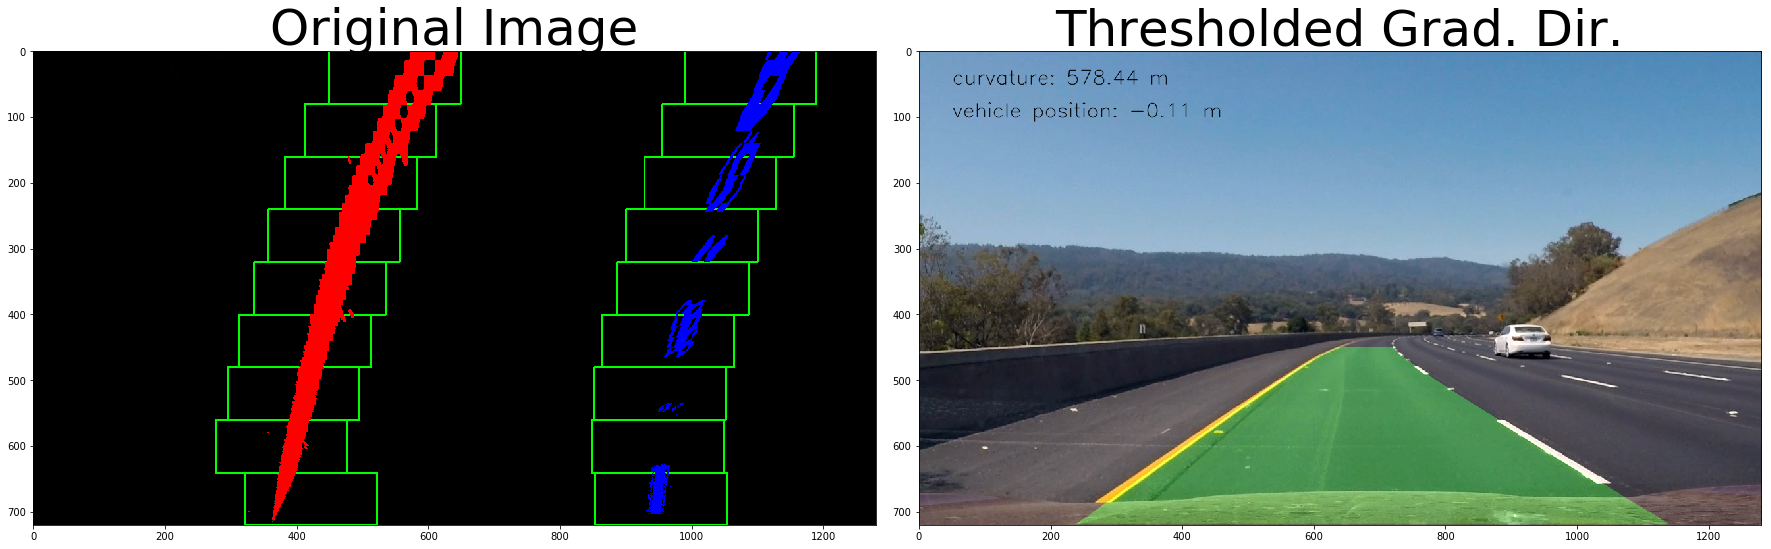

In [143]:
# Run the function
imageName = 'test3.jpg' #generated41s_g generated23s generated30s

proc_image, unwarped_result = process_image(imageName)
image = mpimg.imread('test_images/'+imageName)
cv2.imwrite('output_images/output.jpg', cv2.cvtColor(unwarped_result, cv2.COLOR_RGB2BGR))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(proc_image) #image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(unwarped_result, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [144]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video test_videos_output/project_video_expand_filter.mp4
[MoviePy] Writing video test_videos_output/project_video_expand_filter.mp4


100%|█████████▉| 1260/1261 [04:37<00:00,  2.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_expand_filter.mp4 

CPU times: user 6min 46s, sys: 1min 41s, total: 8min 28s
Wall time: 4min 38s


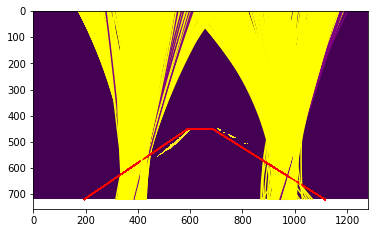

In [58]:
white_output = 'test_videos_output/project_video_expand_filter.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))